# Bitcoin and random forests
## Trying to generate a sensible dependent value. 

The goal of this notebook is to think about a binary dependent variable and employ a random forest. 

First, the following metrics are going to be calculated: 
 - 20 candle moving average
 - volume weighted price
 - monthly, weekly, daily levels

Afterwards, think of a good dependent variable. 

In [1]:
# import data from septembre of 2022 since it was rather stable during this period
import pandas as pd
import numpy as np
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    df = pd.read_csv("/kaggle/input/btcusdt-2023-6-9/btcusdt-2023-6_9.csv", index_col=0).reset_index(drop=True)
else:
    df = pd.read_csv("btc-data/btcusdt-2023-6_9.csv", index_col=0).reset_index(drop=True)


print(df.shape)
df.head(3)

(11716, 6)


,time,open,high,low,close,vol
0,2023.06.01 00:00,27103.1,27108.1,27080.6,27096.9,386.675
1,2023.06.01 00:15,27096.9,27096.9,27036.7,27047.0,408.680
2,2023.06.01 00:30,27047.0,27077.4,27041.0,27054.9,275.080


In [2]:
# transform to date_time
df["time"] = pd.to_datetime(df["time"])

# Extracting day and hour
df["day"] = df["time"].dt.day
df["hour"] = df["time"].dt.hour

# the 10-day moving average
df["10MA"] = df["close"].rolling(window=10).mean()

# Calculate the standard deviation of the closing prices over the same 20-day period
df["10STD"] = df["close"].rolling(window=10).std()

# volume weighted close price
df["vwap"] = df.close/df.vol

# Bollinger Band: 
# simple_moving_average(20) + std x 2 | sma - std x 2
df["bb_upper_band"] = df["10MA"] + 2 * df["10STD"]
df["bb_lower_band"] = df["10MA"] - 2 * df["10STD"]

# daily_open
df["daily_open"] = df.groupby(df["day"])["open"].transform("first")

# daily_close
df["daily_close"] = df.groupby(df["day"])["close"].transform("first")


# Calculate On-Balance Volume (OBV)
df["change"] = df["close"].diff()
df["direction"] = df["change"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
df["obv"] = df["vol"] * df["direction"]
df["obv"] = df["obv"].cumsum()

# define variables that look 1 to three periods into the future
df["open_p1"] = df["open"].shift(1)
df["high_p1"] = df["high"].shift(1)
df["low_p1"] = df["low"].shift(1)
df["close_p1"] = df["close"].shift(1)

df["open_p2"] = df["open"].shift(2)
df["high_p2"] = df["high"].shift(2)
df["low_p2"] = df["low"].shift(2)
df["close_p2"] = df["close"].shift(2)

df["open_p3"] = df["open"].shift(3)
df["high_p3"] = df["high"].shift(3)
df["low_p3"] = df["low"].shift(3)
df["close_p3"] = df["close"].shift(3)


print(df.shape)
df[18:].head(3) # data set starts with the 20th observation since the first 20 rows had to be used for the moving average

(11716, 30)


,time,open,high,low,close,vol,day,hour,10MA,10STD,...,low_p1,close_p1,open_p2,high_p2,low_p2,close_p2,open_p3,high_p3,low_p3,close_p3
18,2023-06-01 04:30:00,27131.7,27152.2,27103.3,27103.4,657.897,1,4,27172.38,82.346447,...,27089.4,27131.7,27060.2,27135.0,27050.0,27115.9,27103.6,27103.6,27012.0,27060.2
19,2023-06-01 04:45:00,27103.4,27144.9,27064.5,27069.3,960.815,1,4,27160.82,88.292969,...,27103.3,27103.4,27115.9,27133.0,27089.4,27131.7,27060.2,27135.0,27050.0,27115.9
20,2023-06-01 05:00:00,27069.3,27078.8,27036.7,27044.4,451.196,1,5,27140.56,89.556180,...,27064.5,27069.3,27131.7,27152.2,27103.3,27103.4,27115.9,27133.0,27089.4,27131.7


<Axes: >

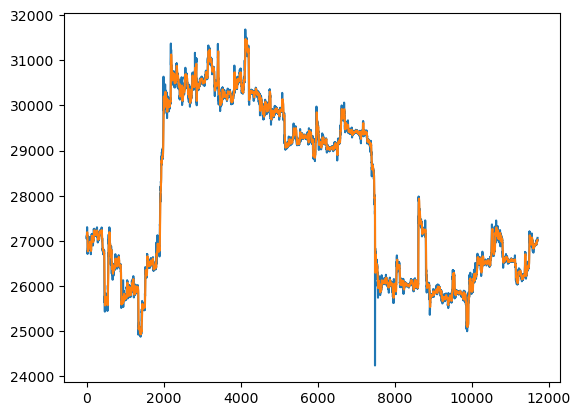

In [3]:
# check if everything looks ok
df.close.plot()
df["10MA"].plot()

# Dependent variable 

Now it is time to think about a dependent variable. 

First, I would like to try a binary variable which incorporates something with a moving averge kind of thing. 

Therefore: If the price is out of the Bollinger Bands, has the following candle [=some price in the range from high to low] a price that is at least 0.5% away from the value of the Bollinger Band value? 

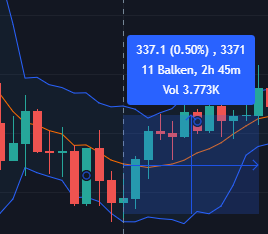

In [4]:
from IPython.display import Image
if iskaggle:
    img= Image(filename="/kaggle/input/dep-var1/dep_var1.png")
else:
    img = Image(filename="figs/dep_var1.png")
img

In [5]:
# simple example: 

candle_low = 25000
bb_lower = 25100
candle_high_plus1 = 25300

print(candle_low < bb_lower)
print(bb_lower*1.005 < candle_high_plus1)
print("Both are true, therefore it is a goal for the model and afterwards maybe a trade worth taking, based on the model.")

True
True
Both are true, therefore it is a goal for the model and afterwards maybe a trade worth taking, based on the model.


In [6]:
# GOAL:
# if the price is outside of the bollinger bands: 
#    is the next candle 0.5% away from the bb value?

# Create a new column "y_bb" initialized with False
df["y_bb"] = False

# Check conditions and set values accordingly
df.loc[(df["low"] < df["bb_lower_band"]) & (df["high_p1"] > df["bb_lower_band"]*1.005), "y_bb"] = True
df.loc[(df["high"] > df["bb_upper_band"]) & (df["low_p1"] < df["bb_upper_band"]/1.005), "y_bb"] = True

# Random Forest
Now, we have all the independent variables gathered and a binary independent variable created. 

In [7]:
df.columns

Index(['time', 'open', 'high', 'low', 'close', 'vol', 'day', 'hour', '10MA',
       '10STD', 'vwap', 'bb_upper_band', 'bb_lower_band', 'daily_open',
       'daily_close', 'change', 'direction', 'obv', 'open_p1', 'high_p1',
       'low_p1', 'close_p1', 'open_p2', 'high_p2', 'low_p2', 'close_p2',
       'open_p3', 'high_p3', 'low_p3', 'close_p3', 'y_bb'],
      dtype='object')

In [8]:
from sklearn.model_selection import train_test_split

cols = ['open', 'high', 'low', 'close', 'vol', 'day', 'hour', '10MA', 
       '10STD', 'vwap', 'bb_upper_band', 'bb_lower_band', 'daily_open', 
       'daily_close', 'change', 'direction', 'obv']

df = df.dropna()
X,y = df[cols],df["y_bb"]

# do the train test splitting 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y) #stratify on variable y

In [9]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier() # min_samples_leaf=4
forest.fit(X_train, y_train)

RandomForestClassifier()

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred_test = forest.predict(X_test)
accuracy_score(y_test, y_pred_test)

0.9644687393235395

In [11]:
conf_m = confusion_matrix(y_test, y_pred_test)
conf_m

array([[2758,   30],
       [  74,   65]])

<Axes: >

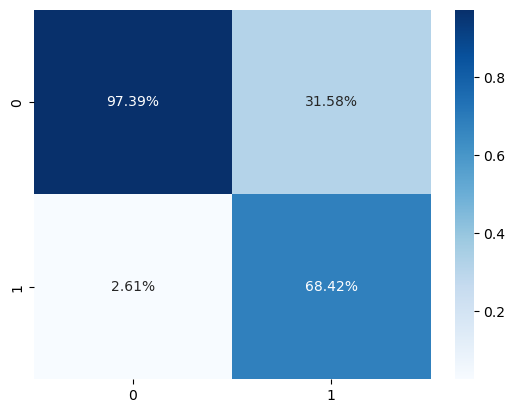

In [12]:
import seaborn as sns
sns.heatmap(conf_m/np.sum(conf_m,axis=0), annot=True, fmt='.2%', cmap='Blues')

In [13]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       False       0.97      0.99      0.98      2788
        True       0.68      0.47      0.56       139

    accuracy                           0.96      2927
   macro avg       0.83      0.73      0.77      2927
weighted avg       0.96      0.96      0.96      2927



Overall, it seems like a useful model. However it is spurious that the precision is at exactly 75%. 

More ways to improve the model would be to 
- get more data
- add other symbols, like ETH, EUR/USD pair, S&P 500, etc.

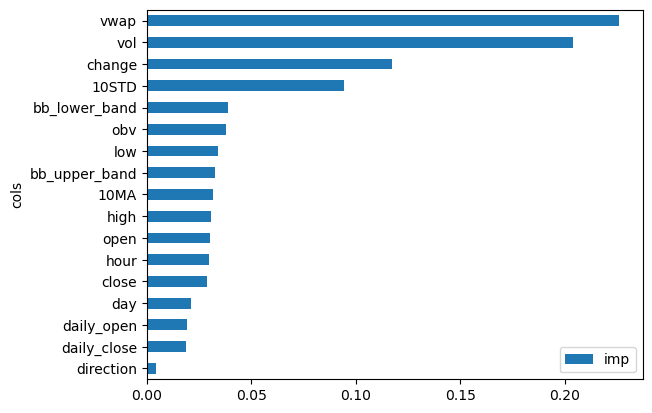

In [19]:
pd.DataFrame(dict(cols=X_train.columns, imp=forest.feature_importances_)).sort_values(by=['imp']).plot('cols', 'imp', 'barh');